## CNN Training
#### In this notebook we train a CNN for detecting mitosis using the hard GT mitosis and the negative samples previously extracted 
#### The adversarial lib uses gradient reversal layer from https://github.com/michetonu/gradient_reversal_keras_tf

In [39]:
import sys
sys.version
sys.version_info

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)

In [137]:
import time

import keras
from keras.applications.densenet import DenseNet121
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras import activations, Model
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, Deconvolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense, Dropout, Activation 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import *
from matplotlib.pyplot import imread
import random
from sklearn.metrics.pairwise import manhattan_distances

from os.path import join, basename, dirname, exists  
import os  
import glob
import numpy as np
import csv
import matplotlib.pyplot as plt
from PIL import Image

sys.path.insert(0, 'utils')
import utils_patches
import config
import importlib
importlib.reload(utils_patches)#Debugging purposes, not recomended in final version of the code!
from utils_patches import localize_mitosis, localize_mitosis_patches, extract_patches, load_image, plot_image
#import utils_patches import *
import configparser


In [138]:
MaxPooling2D??

In [3]:
#Definition of the CNN model
kernel_size = (4,4)
input_shape = (63,63,3)
nb_filters = 16 
pool_size = 2
def mitosis_model(lr,clip_norm):
    model_mitosis = Sequential() #Is sequential because all the 
    #Block 0
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),
                            padding='valid',
                            input_shape=input_shape))
    model_mitosis.add(Activation('relu'))
    #Block 1
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),activation='relu'))
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('relu'))
    model_mitosis.add(MaxPooling2D(pool_size=pool_size))
    model_mitosis.add(Dropout(0.25))
    #Block 2
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),activation='relu'))
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('relu'))
    model_mitosis.add(MaxPooling2D(pool_size=pool_size))
    model_mitosis.add(Dropout(0.25))
    #Block 3
    model_mitosis.add(Convolution2D(nb_filters, (kernel_size[0], kernel_size[1]),activation='relu'))
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('relu'))
    model_mitosis.add(MaxPooling2D(pool_size=pool_size))
    model_mitosis.add(Dropout(0.25))
    model_mitosis.add(Flatten())
    #Block 4
    model_mitosis.add(Dense(128))#, activation= 'relu')
    model_mitosis.add(BatchNormalization())
    model_mitosis.add(Activation('softmax'))
    model_mitosis.add(Dropout(0.25))
    model_mitosis.add(Dense(2,activation='softmax'))

    #Defining the optimizer
    sgd_opt = SGD(lr=lr, momentum=0.9, decay=0.9, nesterov=True)

    if clip_norm:
        adam_opt = Adam(lr,clipnorm=1,decay=0.9)
    else:
        adam_opt = Adam(lr)

    model_mitosis.compile(loss='categorical_crossentropy',
              optimizer=adam_opt ,
              metrics=['mae','acc'])
    return model_mitosis

In [131]:
model_mitosis.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 16)        784       
_________________________________________________________________
activation_1 (Activation)    (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 16)        4112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 57, 57, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 57, 57, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 16)        0         
__________

In [4]:
# Define a function to read images from disk and convert them to xyc format in a desire output range.
def load_image(input_path, range_min=0, range_max=1):
    
    # Read image data (x, y, c) [0, 255]
    image = imread(input_path)
    
    # Convert image to the correct range
    image = (image / 255) * (range_max - range_min) + range_min 

    return image

# Define a function to plot a batch or list of image patches in a grid
def plot_image(images, images_per_row=8):
    
    fig, axs = plt.subplots(int(np.ceil(len(images)/images_per_row)), images_per_row)
    
    c = 0
    for ax_row in axs:
        for ax in ax_row:
            if c < len(images):
                ax.imshow(images[c])
            ax.axis('off')            
            c += 1
    plt.show()


Building generator for patches in /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/training/
(32, 63, 63, 3)
(32, 2)


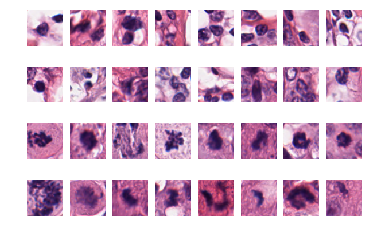

In [5]:
##Building the generators for balanced negative-positive batches

class simplePatchGenerator(object):
    def __init__(self, input_dir, batch_size, img_shape = (63,63,3), augmentation_fn=None):
        print("Building generator for patches in " + input_dir)
        # Params
        self.input_dir = input_dir  # path to patches in glob format
        self.batch_size = batch_size  # number of patches per batch
        self.augmentation_fn = augmentation_fn  # augmentation function
        self.img_shape = img_shape
        self.list_positive = glob.glob(input_dir + 'mitosis/*.png')
        self.list_negative = glob.glob(input_dir + 'non_mitosis/*.png')
        self.encoder = OneHotEncoder(sparse=False)
        

        self.n_samples = len(self.list_negative +self.list_positive)
        self.n_batches = self.n_samples // self.batch_size
    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        # Provide length in number of batches
        return self.n_batches

    def next(self):
        # Build a mini-batch
        paths_negatives = random.sample(self.list_negative,self.batch_size//2) #self.df.loc[self.df['label'] == 0, :].sample(self.batch_size//2, replace = True)
        paths_positives = random.sample(self.list_positive,self.batch_size//2) #self.df.loc[self.df['label'] == 0, :].sample(self.batch_size//2, replace = True)
        images = []
        labels = np.concatenate((np.zeros((self.batch_size//2,1)), np.ones((self.batch_size//2,1))),axis=0)
        label_idx = 0
        for pathimg in paths_negatives+paths_positives:
            try:
                # Read image path
                # Read data and label
                image = load_image(pathimg)
                # Data augmentation
                if self.augmentation_fn:
                    image = self.augmentation_fn(image)

                # Append
                if image.shape != self.img_shape:
                    images.append(images[-1])
                    labels[label_idx] = labels[label_idx-1]
                else:
                    images.append(image)
                label_idx+=1
            except Exception as e:
                print('Failed reading img {idx}...'.format(idx=pathimg))
                print(e)
            label_idx += 1
            
        batch_x = np.stack(images).astype('float32')
        batch_y = np.stack(labels).astype('float32')

        return batch_x, self.encoder.fit_transform(batch_y)#batch_y

# Test the data generator
training_gen = simplePatchGenerator(
    input_dir='/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/training/', 
    batch_size=32,
    img_shape = (63,63,3)
)

for batch_x, batch_y in training_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x*255, images_per_row=8) 
    break

Building generator for patches in /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/val/
(32, 63, 63, 3)
(32, 2)


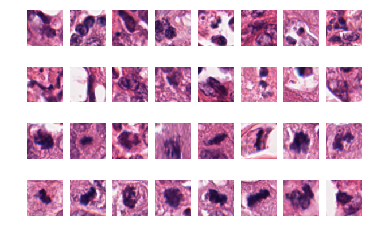

In [135]:
val_gen = simplePatchGenerator(
    input_dir='/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/val/', 
    batch_size=32,
    img_shape = (63,63,3)
)
for batch_x, batch_y in val_gen:
    print(batch_x.shape)
    print(batch_y.shape)
    plot_image(batch_x*255, images_per_row=8)
    break
#batch_y

In [7]:
#Defining the CallBacks for tensorboard visualization and for earlystopping of the model
exp_name = 'baseline_lafrange'
checkpointer = ModelCheckpoint(filepath='/home/sebastian/local_experiments/staining/models/lafrange_model/'+exp_name+'decay_skL_softmax_ADAM_weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=False)
tb_callback = TensorBoard(log_dir='/home/sebastian/local_experiments/staining/logs'+exp_name+'/', histogram_freq=0, batch_size=64, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [8]:
batch_size = 64
lambda_m = 0.1
epoch_size = 4000
Tp_min, Fp_max = 400, 100
model_mitosis = mitosis_model(lambda_m,True)


In [9]:
max_epochs = 10
trainPhase = False
if trainPhase:    
    model_mitosis.fit_generator(training_gen, epochs=max_epochs,verbose=1,callbacks=[checkpointer,tb_callback], validation_data=val_gen, validation_steps=20,steps_per_epoch=2000)

In [10]:
#Loading best model to check performance on test dataset
path_model_weights ='/home/sebastian/local_experiments/staining/models/lafrange_model/baseline_lafrangedecay_skL_softmax_ADAM_weights.10-0.50.hdf5'
model_mitosis.load_weights(path_model_weights)

In [11]:
#The path should be changed according to the ppartition being processed, i.e., training/val/test
path_test_images = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/test/mitosis/'
list_test_imgs = glob.glob(path_test_images + '**.png')
test_batches_paths = [list_test_imgs[i:i+64] for i in range(0,len(list_test_imgs),64)]

path_neg_test_images = '/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/test/non_mitosis/'
list_neg_test_imgs = glob.glob(path_neg_test_images + '**.png')
test_neg_batches_paths = [list_neg_test_imgs[i:i+64] for i in range(0,len(list_neg_test_imgs),64)]
print(len(list_test_imgs),len(list_neg_test_imgs))

533 12317


In [12]:
def evaluate_threshold_validation(model,validation_images_path,perf_meassure='f1'):
    list_val_imgs = glob.glob(validation_images_path + 'mitosis/' +  '**.png')
    val_batches_paths = [list_val_imgs[i:i+64] for i in range(0,len(list_val_imgs),64)]
    list_neg_test_imgs = glob.glob(validation_images_path + 'non_mitosis/' +'**.png')
    val_neg_batches_paths  = [list_neg_test_imgs[i:i+64] for i in range(0,len(list_neg_test_imgs),64)]
    
    #Computing probabilities for mitotic patches
    probabilites = []
    for batch in val_batches_paths:
        images_batch = []
        for pathimg in batch:
            image = load_image(pathimg)
            images_batch.append(image)    
        probabilites.append(model_mitosis.predict_proba(np.array(images_batch)))
        #print(model_mitosis.predict_classes(np.array(test_batches_paths[0])))
    concat_probs = np.array([j for i in probabilites for j in i])
    
    #Computing probabilities for non mitotic patches
    neg_probabilites = []
    for batch in val_neg_batches_paths:
        images_batch = []
        for pathimg in batch:
            image = load_image(pathimg)
            images_batch.append(image)    
        neg_probabilites.append(model_mitosis.predict_proba(np.array(images_batch)))
        #print(model_mitosis.predict_classes(np.array(test_batches_paths[0])))
    concat_neg_probs = np.array([j for i in neg_probabilites for j in i])
    gt_labels = np.concatenate((np.ones((len(concat_probs),1)),np.zeros((len(concat_neg_probs),1))),axis=0)
    all_probs = np.concatenate((concat_probs,concat_neg_probs),axis=0)
    fpr, tpr, thresholds = roc_curve(gt_labels, all_probs[:,1], pos_label=1, sample_weight=None, drop_intermediate=True)
    roc_auc = auc(fpr,tpr)
    max_f1 = 0
    best_thres = 0
    for cur_thres in thresholds:
        cur_f1 = f1_score(gt_labels, all_probs[:,1]>cur_thres, average='macro')
        if cur_f1>max_f1:
            print(max_f1)
            max_f1 = cur_f1
            best_thres = cur_thres
    print("Best threshold found in validation is: " + str(best_thres) +  "; With f1="+str(max_f1))
    print(gt_labels.shape,all_probs.shape)
    best_threshold = 0
    return best_thres,max_f1,roc_auc

In [13]:
best_val_thres,max_f1,roc_auc = evaluate_threshold_validation(model_mitosis,'/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/patches/hnm_set/val/',perf_meassure='f1')

0
0.4814814814814815
0.5438717860025366
0.5526332794830371
0.5610506126460285
0.6436606915086645
0.6512320606552937
0.7119402199652687
0.7142590740877685
0.7184592429267922
0.7185513928086693
0.7224938170452304
0.7320207820617992
0.737641811048494
0.7624930850082979
0.7634355937486085
0.7643312623745476
0.7672199158931698
0.7720891824938068
0.772775506012644
0.7823573511037067
0.7827402985634095
0.7831649831649832
0.785130998356786
Best threshold found in validation is: 0.8348074; With f1=0.7887731229202086
(1288, 1) (1288, 2)


/home/sebastian/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
total_fp  = 0 
probabilites = []
for batch in test_batches_paths:
    images_batch = []
    for pathimg in batch:
        image = load_image(pathimg)
        images_batch.append(image)    
    probabilites.append(model_mitosis.predict_proba(np.array(images_batch)))
    #print(model_mitosis.predict_classes(np.array(test_batches_paths[0])))
concat_probs = np.array([j for i in probabilites for j in i])
print(len(concat_probs))


533


In [15]:
total_fp  = 0 
neg_probabilites = []
for batch in test_neg_batches_paths:
    images_batch = []
    for pathimg in batch:
        image = load_image(pathimg)
        images_batch.append(image)    
    neg_probabilites.append(model_mitosis.predict_proba(np.array(images_batch)))
    #print(model_mitosis.predict_classes(np.array(test_batches_paths[0])))
concat_neg_probs = np.array([j for i in neg_probabilites for j in i])
print(len(concat_neg_probs))

12317


In [16]:
gt_labels = np.concatenate((np.ones((len(concat_probs),1)),np.zeros((len(concat_neg_probs),1))),axis=0)
all_probs = np.concatenate((concat_probs,concat_neg_probs),axis=0)
print(gt_labels.shape,all_probs.shape)

(12850, 1) (12850, 2)


In [17]:
fpr, tpr, thresholds = roc_curve(gt_labels, all_probs[:,1], pos_label=1, sample_weight=None, drop_intermediate=True)
roc_auc = auc(fpr,tpr)

In [18]:
f1_test = f1_score(gt_labels, all_probs[:,1]>best_val_thres, average='macro')
print("F1 score in TEST : " + str(f1_test)) 

F1 score in TEST : 0.6425052748093628


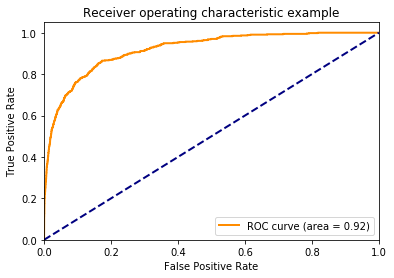

In [19]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


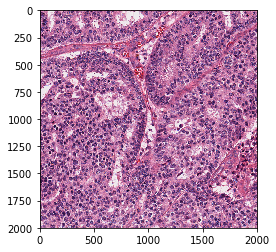

In [445]:
cases_test = [13,14,15,16,17,18,19,20,21,22,23] 
#Loading one image and doing dense prediction using a sliding window:
#ex_img = np.array(Image.open('/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/13/01.tif'))
ex_img = load_image('/mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_2/15/25.tif', range_min=0, range_max=1)
plt.imshow(ex_img)

In [164]:
np.concatenate((cur_thing,cur_thing),axis=0).shape

(3874, 63, 63, 3)

In [369]:
#cur_thing_s = np.concatenate((cur_thing,cur_thing),axis=0)        
#cur_thing_ss = np.concatenate((cur_thing_s,cur_thing_s),axis=0)
#cur_thing_sss = np.concatenate((cur_thing_ss,cur_thing_ss),axis=0)
#cur_thing_ssss = np.concatenate((cur_thing_sss,cur_thing_sss),axis=0)
limit_gpu_array = np.random.rand(14866,63,63,3)
print(cur_thing_s.shape,cur_thing_ss.shape,cur_thing_sss.shape,cur_thing_ssss.shape)

(3874, 63, 63, 3) (7748, 63, 63, 3) (15496, 63, 63, 3) (30992, 63, 63, 3)


In [429]:
start = time.time()

l = model_mitosis.predict_proba(limit_gpu_array,batch_size=limit_gpu_array.shape[0])

#print(str(cur_thing_ssss.shape[0]))
end = time.time()
print("Time elapsed on variable batch size inference :" + str(end - start))


Time elapsed on variable batch size inference :1.569958209991455


In [449]:
start = time.time()
all_probs_old = compute_probs_sliding_window_old_v2(model_mitosis,ex_img)
end = time.time()
print("Time for computing all dense predictions of a single image: " + str(end - start))

1936 iterations - Time elapsed on gpu + comprehension :518.3395547866821
Time for computing all dense predictions of a single image: 518.3562548160553


In [447]:
start = time.time()
all_probs = compute_probs_sliding_window_v1(model_mitosis,ex_img)
end = time.time()
print("Time for computing all dense predictions of a single image: " + str(end - start))

Computing probs for row 0
Computing probs for row 100
Computing probs for row 200
Computing probs for row 300
Computing probs for row 400
Computing probs for row 500
Computing probs for row 600
Computing probs for row 700
Computing probs for row 800
Computing probs for row 900
Computing probs for row 1000
Computing probs for row 1100
Computing probs for row 1200
Computing probs for row 1300
Computing probs for row 1400
Computing probs for row 1500
Computing probs for row 1600
Computing probs for row 1700
Computing probs for row 1800
Computing probs for row 1900
Time for computing all dense predictions of a single image: 737.5065138339996


In [419]:
print(all_probs.shape)
print(np.array(all_probs_old).shape)

(1938, 1938, 2)
(1937, 1937, 2)


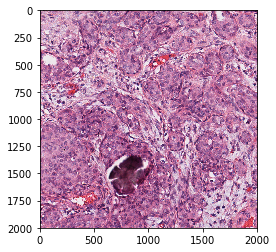

In [402]:
plt.imshow(ex_img)

0.90054256

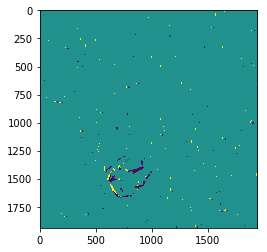

In [428]:
plt.imshow(all_probs[:,:,1])
np.max(all_probs[:,:,0])

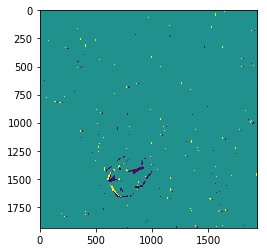

In [421]:
plt.imshow(np.array(all_probs_old)[:,:,1])

In [ ]:
cur_batch_row_2= cur_batch_row +1
for i in range(20):
    cur_batch_row_2= cur_batch_row_2 +2
    cur_batch_row = np.concatenate((cur_batch_row,cur_batch_row_2),axis=0)

In [39]:
i = 0
cur_batch_row = np.squeeze(np.array([[ex_img[i:i+63,j:j+63,:]/255. for j in range(ex_img.shape[1]-63)]]))

len(cur_batch_row)


1937

In [432]:
def compute_probs_sliding_window_old_v2(model_mitosis,ex_img):
    probs_row = []
    stride_x,stride_y = 63,63
    start = time.time()
    for i in range(ex_img.shape[0]-stride_x): #This is a nice use case of list comprehension, for GPU mem limists is not possible to use only one line ranging also in the rows dim
        cur_batch_row = np.squeeze(np.array([[ex_img[i:i+63,j:j+63,:] for j in range(ex_img.shape[1]-stride_y)]]))        
        probs_row.append(model_mitosis.predict_proba(cur_batch_row,batch_size=cur_batch_row.shape[0]))
    end = time.time()
    print(str(i)+" iterations - Time elapsed on gpu + comprehension :" + str(end - start))
    return (np.array(probs_row))

In [430]:
# Sliding window CNN approach using list-comprehensions to speed up a little bit
def compute_probs_sliding_window_v1(model_mitosis,ex_img):
    kk_r = extract_patches(ex_img[:,:,0], patch_shape=63, extraction_step=1)[0]
    kk_g = extract_patches(ex_img[:,:,1], patch_shape=63, extraction_step=1)[0]
    kk_b = extract_patches(ex_img[:,:,2], patch_shape=63, extraction_step=1)[0]
    probs_row = []
    for i in range(kk_r.shape[0]): #This is a nice use case of list comprehension, for GPU mem limits is not possible to use only one line, i.e., ranging also in the rows dim
        cur_thing_r = np.squeeze(np.array([[kk_r[i,j,:,:] for j in range(kk_r.shape[1])]]))
        cur_thing_g = np.squeeze(np.array([[kk_g[i,j,:,:] for j in range(kk_r.shape[1])]]))
        cur_thing_b = np.squeeze(np.array([[kk_b[i,j,:,:] for j in range(kk_r.shape[1])]]))
        start = time.time()
        cur_thing = np.stack((cur_thing_r, cur_thing_g, cur_thing_b),axis=-1)
        #start = time.time()
        probs_row.append(model_mitosis.predict_proba(cur_thing,batch_size=cur_thing.shape[0]))
        #probs_row.append(model_mitosis.predict_proba(np.concatenate((cur_thing_sss,cur_thing_sss),axis=0)))
        
        #print("Time elapsed on gpu :" + str(end - start))
        if i%100== 0:
            print("Computing probs for row " + str(i))
        end = time.time()
    return(np.array(probs_row))

In [374]:
def compute_detectcions_performance(D,coords_patches,distance_gt_pxs):
    #D is asume to be a list with items: [(coord_x,coord_y), mf[(coord_x,coord_y)]]
    tp=0
    fp = 0
    fn = 0
    tp_locs = []
    for item in D:
        is_tp = False
        for coord_gt in coords_patches:
            dist_item = manhattan_distances([[item[0][0], item[0][1]]], [[coord_gt[0], coord_gt[1]]])[0][0] 
            if dist_item < distance_gt_pxs: #centroid closer than 30 pixels is cosidered GT 
                tp +=1
                tp_locs.append(item)
                is_tp = True
        if is_tp == False:
            fp +=1
    for coord_gt in coords_patches:
        is_fn = True
        for item in D:
            dist_item = manhattan_distances([[item[0][0], item[0][1]]], [[coord_gt[0], coord_gt[1]]])[0][0]
            if dist_item < distance_gt_pxs:
                is_fn = False
        if is_fn:
            fn +=1
    P = tp/(tp+fp)
    R = tp/(tp+fn)
    if (P+R) == 0:
        f1 = 0
        print("Addition of P and R equal 0!")
    else:
        f1 = 2*(P*R)/(P+R)
    return f1,P,R, tp, fp,fn

In [375]:
distance_gt_pxs = 30
D = [[(10, 29), 0.897356390953064], [(100, 100), 0.897356390953064], [(500,500), 0.897356390953064]]
coords_patches = [[ 100, 100],[15, 5],[600, 600]]
print(D[0:3])

print(coords_patches)
f1,P,R, tp, fp,fn = compute_detectcions_performance(D,coords_patches,distance_gt_pxs)
print(f1,P,R,tp, fp,fn)


[[(10, 29), 0.897356390953064], [(100, 100), 0.897356390953064], [(500, 500), 0.897356390953064]]
[[100, 100], [15, 5], [600, 600]]
0.6666666666666666 0.6666666666666666 0.6666666666666666 2 1 1


In [438]:
def local_maxima_supression(all_probs,radius,best_val_thres):
    #radius = 32
    D = []
    mf = all_probs[:,:,1]
    bin_mask_mf = np.array(mf> best_val_thres,dtype=int)
    all_pairs_p = list(zip(np.nonzero(bin_mask_mf)[0],np.nonzero(bin_mask_mf)[1]))
    while(len(all_pairs_p)>0):
        #plt.imshow(bin_mask_mf)
        p_m = np.unravel_index(np.argmax(np.multiply(mf,bin_mask_mf)), mf.shape) 
        p_m_val = np.max(np.multiply(mf,bin_mask_mf))
        print(p_m,p_m_val,len(all_pairs_p))
        D.append((p_m,p_m_val))
        for item in all_pairs_p:
            if manhattan_distances([[item[0], item[1]]], [[p_m[0], p_m[1]]])[0][0] < 2*radius:
                bin_mask_mf[item[0],item[1]] = 0 #This makes all_pairs_p decrease in length 
        all_pairs_p = list(zip(np.nonzero(bin_mask_mf)[0],np.nonzero(bin_mask_mf)[1]))
        return D #The final detections

In [377]:
list_csv = glob.glob(config.PATH_GT + '**/*.csv')
print(len(list_csv))
dict_image_csv = d={i:[] for i in list(1+np.arange(73))}
for item in list_csv:
    casenum = int(item.split('/')[-2])
    if casenum in dict_image_csv.keys():
        dict_image_csv[casenum].append(item)
    else:
        dict_image_csv[casenum] = []
print(dict_image_csv.keys())

587
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73])


In [436]:
all_probs.shape

(1938, 1938, 2)

In [443]:
start = time.time()

D = local_maxima_supression(all_probs,radius,best_val_thres)
end = time.time()
print("Time elapsed on variable batch size inference :" + str(end - start))


Time elapsed on variable batch size inference :0.09350991249084473


In [442]:
D

In [379]:
#Reading the GT coordinates for the current test case, any detection closer than 20 pixels  to a center will be
#considered as a true positive
stride_x,stride_y = 63,63
radius = 32
distance_gt_pxs = 22

all_meassures = []
for idx_case in cases_test:
    for csv_num in range(len(dict_image_csv[idx_case])):
        print("Computing performance for " +str(dict_image_csv[idx_case][csv_num]) )
        csv_path = dict_image_csv[idx_case][csv_num]
        coords_patches, patches, ex_img = localize_mitosis_patches(csv_path,return_img = True)
        #all_probs = compute_probs_sliding_window(model_mitosis,ex_img,stride_x,stride_y)
        all_probs = compute_probs_sliding_window(model_mitosis,ex_img)
        D = local_maxima_supression(all_probs,radius,best_val_thres)
        all_meassures.append(compute_detectcions_performance(D,coords_patches,distance_gt_pxs))
        print(coords_patches,  ex_img.shape)

Computing performance for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_ground_truth/13/06.csv
Computed coords and patches for /mnt/nas3/bigdatasets/Desuto/tupac_mitosis/mitoses_image_data_part_1/13/06.tif
31008
Time elapsed on patch stacking :0.3416769504547119
Time elapsed on gpu :2.4079642295837402
Computing probs for row 0
31008
Time elapsed on patch stacking :0.3636200428009033
Time elapsed on gpu :2.3145217895507812
31008
Time elapsed on patch stacking :0.35095906257629395
Time elapsed on gpu :2.4123494625091553
31008
Time elapsed on patch stacking :0.3438384532928467
Time elapsed on gpu :2.339465379714966
31008
Time elapsed on patch stacking :0.3412003517150879
Time elapsed on gpu :2.2635297775268555
31008
Time elapsed on patch stacking :0.3404567241668701
Time elapsed on gpu :2.374070167541504
31008
Time elapsed on patch stacking :0.34818148612976074
Time elapsed on gpu :2.3799753189086914
31008
Time elapsed on patch stacking :0.34014272689819336
Time elapsed on gpu :2.356

KeyboardInterrupt: 

In [87]:
np.expand_dims(ex_img,axis=0).shape

(1, 2000, 2000, 3)

In [136]:
#f1,P,R, tp, fp,fn 
tp = np.array(all_meassures)[:,3].sum()
fp = np.array(all_meassures)[:,4].sum()
fn = np.array(all_meassures)[:,5].sum()
print(tp,fp,fn)

NameError: name 'all_meassures' is not defined

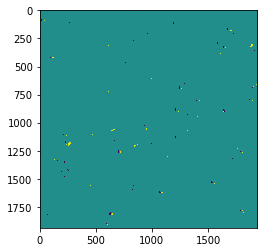

In [83]:
plt.imshow(all_probs[:,:,0])

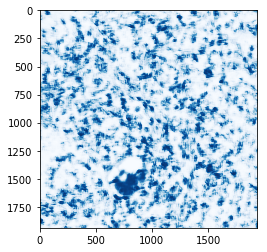

In [51]:
#mycmap = transparent_cmap(plt.cm.hot)
import scipy.misc

fig, ax = plt.subplots(1, 1)
ax.imshow(np.multiply(all_probs[:,:,0],255),cmap=plt.cm.Blues)
img_fname = 'Mf_img_' + str(2) + '.png'
out_file_path = '/home/sebastian/local_experiments/staining/results/tupac/images/'+img_fname
#scipy.misc.imsave(out_file_path, np.multiply(kk,255),cmap=plt.cm.Blues)
#fig.savefig('/home/sebastian/pp.png')

plt.imsave(
            out_file_path,
            np.multiply(all_probs[:,:,0],255),
            cmap=plt.cm.Blues,
            vmin=0,
            vmax=255)

In [61]:
def nonmaximasupression(Mf,threshold,radius):
    return D,smoothed_Mf